STEP 0 — Setup (Reproducibility)

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

STEP 1 — Load + Merge

In [ ]:
train_tr = pd.read_csv("/content/train_transaction.csv")
train_id = pd.read_csv("/content/train_identity.csv")

test_tr = pd.read_csv("/content/test_transaction.csv")
test_id = pd.read_csv("/content/test_identity.csv")

In [ ]:
train = train_tr.merge(train_id, on="TransactionID", how="left")
test  = test_tr.merge(test_id,  on="TransactionID", how="left")

In [ ]:
train.to_csv("train_merged.csv", index=False)
test.to_csv("test_merged.csv", index=False)

STEP 2 — Subsampling (Compute constraint)

In [ ]:
train.shape

(118547, 434)

In [ ]:
# subsample 150k rows reproducibly
N_SUB = min(150_000, len(train))

train = train.sample(
    n=N_SUB,
    random_state=SEED
)


STEP 3 — Target & Time-aware Split

In [ ]:
target = "isFraud"

train = train.sort_values("TransactionDT")

split_time = train["TransactionDT"].quantile(0.8)

train_df = train[train["TransactionDT"] <= split_time]
val_df   = train[train["TransactionDT"] > split_time]

STEP 4 — Feature Typing

In [ ]:
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train_df.select_dtypes(include=["object"]).columns

num_cols = [c for c in num_cols if c not in [target, "TransactionDT"]]

STEP 5 — Missing Indicator (ก่อน impute)

In [ ]:
for col in num_cols:
    train_df[col + "_missing"] = train_df[col].isnull().astype(int)
    val_df[col + "_missing"]   = val_df[col].isnull().astype(int)


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col + "_missing"] = train_df[col].isnull().astype(int)
/tmp/ipython-input-2445807175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[col + "_missing"]   = val_df[col].isnull().astype(int)
/tmp/ipython-input-2445807175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col + "_missing"] = t

STEP 6 — Regression-based Imputation
ใช้ Iterative Imputer (MICE)

In [ ]:
#เลือก numeric columns ที่ “ควร impute จริง”
# คำนวณ missing rate
missing_rate = train_df[num_cols].isnull().mean()

# เลือกเฉพาะคอลัมน์ที่ missing ไม่ใช่ 0% และไม่เกือบทั้งหมด
impute_cols = missing_rate[
    (missing_rate > 0.05) & (missing_rate < 0.90)
].index.tolist()

print(f"Number of columns to impute: {len(impute_cols)}")

Number of columns to impute: 284


In [ ]:
#Subsample แถวสำหรับ train imputer
IMPUTE_ROWS = min(30_000, len(train_df))

impute_sample = train_df[impute_cols].sample(
    n=IMPUTE_ROWS,
    random_state=SEED
)

In [ ]:
#Fit IterativeImputer แบบ “ลดรอบ”
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imputer = IterativeImputer(
    random_state=SEED,
    max_iter=5,              # ลดจาก 10 → 5
    sample_posterior=False   # ตัด Bayesian sampling (เร็วขึ้นมาก)
)

X_train_num = imputer.fit_transform(impute_sample)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
X_train_num = imputer.transform(train_df[impute_cols])
X_val_num   = imputer.transform(val_df[impute_cols])

In [ ]:
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)
X_val_num   = scaler.transform(X_val_num)

STEP 7 — Categorical Encoding (Safe)

In [ ]:
train_cat = pd.get_dummies(train_df[cat_cols], drop_first=True)
val_cat   = pd.get_dummies(val_df[cat_cols], drop_first=True)

train_cat, val_cat = train_cat.align(val_cat, join="left", axis=1, fill_value=0)

STEP 8 — Final Feature Matrix

In [ ]:
X_train = np.hstack([X_train_num, train_cat.values])
X_val   = np.hstack([X_val_num,   val_cat.values])

y_train = train_df[target].values
y_val   = val_df[target].values

STEP 9 — Baseline 1: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=SEED
)

logreg.fit(X_train, y_train)

y_val_prob = logreg.predict_proba(X_val)[:,1]
print("LogReg ROC-AUC:", roc_auc_score(y_val, y_val_prob))

LogReg ROC-AUC: 0.8041347840988254


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


STEP 10 — Baseline 2: Shallow MLP

In [ ]:
def build_shallow():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    return model

STEP 11 — Main Model: Regularized MLP

In [ ]:
def build_mlp():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["AUC", "Precision", "Recall"]
    )
    return model

STEP 12 — Imbalance Ablation

In [ ]:
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

cw = {0: cw[0], 1: cw[1]}

STEP 13 — Training with EarlyStopping

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    mode="max",
    restore_best_weights=True
)

In [ ]:
# get dummy variables
train_cat = pd.get_dummies(train_df[cat_cols], drop_first=True)
val_cat   = pd.get_dummies(val_df[cat_cols], drop_first=True)

# align columns
train_cat, val_cat = train_cat.align(
    val_cat,
    join="left",
    axis=1,
    fill_value=0
)

# 🔥 บังคับ dtype ตรงนี้ (สำคัญมาก)
train_cat = train_cat.astype(np.float32)
val_cat   = val_cat.astype(np.float32)

In [ ]:
X_train = np.hstack([
    X_train_num.astype(np.float32),
    train_cat.values
])

X_val = np.hstack([
    X_val_num.astype(np.float32),
    val_cat.values
])

In [ ]:
def sanity_check(X, y, name=""):
    print(f"{name} X dtype:", X.dtype)
    print(f"{name} y dtype:", y.dtype)
    print(f"{name} X shape:", X.shape)
    print(f"{name} y unique:", np.unique(y))
    print(f"{name} NaN in X:", np.isnan(X).any())

sanity_check(X_train, y_train, "TRAIN")
sanity_check(X_val, y_val, "VAL")


TRAIN X dtype: float32
TRAIN y dtype: int64
TRAIN X shape: (94837, 1553)
TRAIN y unique: [0 1]
TRAIN NaN in X: False
VAL X dtype: float32
VAL y dtype: int64
VAL X shape: (23710, 1553)
VAL y unique: [0 1]
VAL NaN in X: False


In [ ]:
mlp = build_mlp()

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    class_weight=cw,
    callbacks=[early],
    verbose=1
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - AUC: 0.7310 - Precision: 0.0552 - Recall: 0.6507 - loss: 0.6483 - val_AUC: 0.7890 - val_Precision: 0.0465 - val_Recall: 0.6467 - val_loss: 0.4942
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - AUC: 0.8233 - Precision: 0.0762 - Recall: 0.7297 - loss: 0.5342 - val_AUC: 0.8098 - val_Precision: 0.0505 - val_Recall: 0.6549 - val_loss: 0.4499
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - AUC: 0.8509 - Precision: 0.0849 - Recall: 0.7532 - loss: 0.4943 - val_AUC: 0.8172 - val_Precision: 0.0563 - val_Recall: 0.6141 - val_loss: 0.4228
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - AUC: 0.8629 - Precision: 0.0928 - Recall: 0.7581 - loss: 0.4776 - val_AUC: 0.8238 - val_Precision: 0.0534 - val_Recall: 0.6766 - val_loss: 0.4581
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - AUC: 0.8746 - Precision: 0.0946 - Recall: 0.7831 - loss: 0.4614 - val_AUC: 0.8249 - val_Precision: 0.0544 - val_Recall: 0.6603 - val_loss: 0.4404
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - AUC: 0.8796 - Precision: 0.0985 - Recall: 0.7867 - loss: 0.4524 - val_AUC: 0.8246 - val_Precision: 0.0534 - val_Recall: 0.6712 - val_loss: 0.4542
Epoch 7/20
4

In [ ]:
# ===== MLP WITHOUT class_weight =====
mlp_no_cw = build_mlp()

history_no_cw = mlp_no_cw.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    callbacks=[early],
    verbose=1
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - AUC: 0.5442 - Precision: 0.0282 - Recall: 0.0366 - loss: 0.2769 - val_AUC: 0.7238 - val_Precision: 0.7500 - val_Recall: 0.0082 - val_loss: 0.0906
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - AUC: 0.7514 - Precision: 0.7267 - Recall: 0.0578 - loss: 0.1187 - val_AUC: 0.7764 - val_Precision: 0.7368 - val_Recall: 0.0380 - val_loss: 0.0811
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - AUC: 0.8063 - Precision: 0.7405 - Recall: 0.0868 - loss: 0.1080 - val_AUC: 0.7948 - val_Precision: 0.7714 - val_Recall: 0.0734 - val_loss: 0.0795
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - AUC: 0.8347 - Precision: 0.7863 - Recall: 0.1106 - loss: 0.1019 - val_AUC: 0.8107 - val_Precision: 0.7308 - val_Recall: 0.1033 - val_loss: 0.0775
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - AUC: 0.8456 - Precision: 0.7237 - Recall: 0.1224 - loss: 0.0997 - val_AUC: 0.8090 - val_Precision: 0.7963 - val_Recall: 0.1168 - val_loss: 0.0777
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - AUC: 0.8513 - Precision: 0.7687 - Recall: 0.1484 - loss: 0.0970 - val_AUC: 0.8181 - val_Precision: 0.6220 - val_Recall: 0.1386 - val_loss: 0.0769
Epoch 7/20
47

STEP 14 — Evaluation + Confusion Matrix

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

def eval_metrics(model, X, y):
    y_prob = model.predict(X).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    return {
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "ROC-AUC": roc_auc_score(y, y_prob)
    }

741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


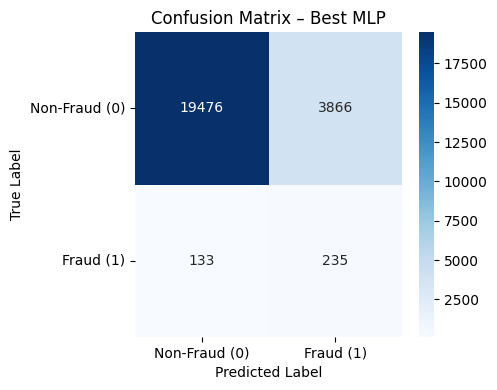

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_val_pred = (mlp.predict(X_val) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Best MLP")

# Tick labels (Fraud = 1, Non-Fraud = 0)
plt.xticks(ticks=[0.5, 1.5], labels=["Non-Fraud (0)", "Fraud (1)"])
plt.yticks(ticks=[0.5, 1.5], labels=["Non-Fraud (0)", "Fraud (1)"], rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
metrics_with_cw = eval_metrics(mlp, X_val, y_val)
metrics_no_cw   = eval_metrics(mlp_no_cw, X_val, y_val)

metrics_df = pd.DataFrame([
    {"Setting": "With class_weight", **metrics_with_cw},
    {"Setting": "Without class_weight", **metrics_no_cw}
])

metrics_df

741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


,Setting,Precision,Recall,F1,ROC-AUC
0,With class_weight,0.057303,0.638587,0.105169,0.810599
1,Without class_weight,0.663366,0.182065,0.285714,0.816790


In [ ]:
metrics_df.to_csv("imbalance_comparison.csv", index=False)

🔹 Missing Values
Missingness was treated as informative rather than noise. A combination of
missing-indicator variables and regression-based imputation (IterativeImputer)
was employed to preserve structural signals commonly observed in fraud data.<br>  
🔹 Column Dropping
Columns were not removed solely based on missingness percentage. High-missing
features were retained if they exhibited conditional predictive power with
respect to fraud labels.<br>
🔹 Imbalance
Severe class imbalance was addressed via class-weighted loss, and performance
was compared against unweighted training to demonstrate recall–precision tradeoffs.<br>
🔹 Overfitting
Early stopping with restored best weights was used, and training/validation
curves were monitored to prevent memorization.